This notebook shows how the library can be used. 
First we read the videos, then we process them and finally we train a model

In [16]:
import pandas as pd
import csv
import os
import re
import numpy as np
import pandas as pd
import cv2
import mediapipe as mp
from token import EXACT_TOKEN_TYPES
from sklearn.metrics import accuracy_score # Accuracy metrics 
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
import multiprocessing
import pickle

In [17]:
# GLOBAL VARIABLES
PATH = r'D:\\Proyectos\\Hands\\HigieneManos' # path to folder
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(model_complexity=0, min_detection_confidence=0.5, min_tracking_confidence=0.5, max_num_hands = 2, ) # modelo

In [18]:
def get_videos_path(root_folder):
    '''
    Function to get all the video paths that are in certain root_folder organized using Stepx folders.
    Parameters
    ----------
    root_folder:str
        The root folder containing the Stepx organized folders.

    Returns
    ----------
    video_paths: list 
        A list of lists where each inner list contains the step number and the corresponding video path.
    '''
    # Regular expression to extract step folder number
    step_regex = re.compile(r'step(\d+)', flags=re.IGNORECASE)  
    video_paths = []

    if not os.path.exists(root_folder):
        print(f"Error: The folder {root_folder} does not exist.")
        return

    # Traverse through the root folder
    for folder_name in os.listdir(root_folder):
        folder_path = os.path.join(root_folder, folder_name)

        # Check if it's a directory and named "step"
        if os.path.isdir(folder_path) and step_regex.search(folder_name.lower()):
            print(f"Reading files in {folder_path}:")

            match = step_regex.search(folder_name)
            step_number = int(match.group(1)) if match else None

            # Traverse through the "step" folder
            for file_name in os.listdir(folder_path):
                file_path = os.path.join(folder_path, file_name)

                # Check if it's a file and has a ".mp4" extension
                if os.path.isfile(file_path) and file_name.lower().endswith(".mp4"):
                    #print(f"Reading {file_path}:")
                    video_paths.append([step_number,file_path])
    return video_paths


In [19]:
video_paths = get_videos_path(PATH+r'\\Data\\Videos')

Reading files in D:\\Proyectos\\Hands\\HigieneManos\\Data\\Videos\Step1:
Reading files in D:\\Proyectos\\Hands\\HigieneManos\\Data\\Videos\Step2:
Reading files in D:\\Proyectos\\Hands\\HigieneManos\\Data\\Videos\Step3:
Reading files in D:\\Proyectos\\Hands\\HigieneManos\\Data\\Videos\Step4:
Reading files in D:\\Proyectos\\Hands\\HigieneManos\\Data\\Videos\Step5:
Reading files in D:\\Proyectos\\Hands\\HigieneManos\\Data\\Videos\Step6:


In [20]:
def predict_step(succes, image, mode, pipeline, return_image=True):
    pass

def get_landmarks_structure(success, image, mode, return_image=True):
    '''
    This function read each frame in a video and returns the landmarks in a array
    Parameters
    ----------
    succes: bool
        Boolean indicating the success of reading a frame.
    image: numpy.ndarray
        The image frame.
    mode: str
        Indicating the mode, either 'video' to load a video or 'capture' when the camera is capturing video.
    return_image: bool
        Indicating wheter or not  show the video.
        
    Returns
    ----------
    success: bool
        Indicating the success of reading a frame
    image: numpu.ndarray
        The image frame
    right_hand_rows: numpy.ndarray or none 
        Array containing the landmarks of the right hand if detected, otherwise None.
    left_hand_rows: numpy.nd.array or none
        Array containing the landmarks of the left hand if detected, otherwise None.
    '''
    if not success: # validate if success
        if mode == 'video': # if not success and is a video, stop
            print("Empty camera frame")
            return False, None, None, None 
        elif mode == 'capture': # if not succes and the camera is capturing wait for the next image
            print("Ignoring empty camera frame.")
            pass
        else:
            print('Select a valid mode')
            return False, None, None, None

    results = hands.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        
    height, width, _ = image.shape
    if results.multi_hand_landmarks:

        for hand_landmarks in results.multi_hand_landmarks:
            mp_drawing.draw_landmarks(
            image,
            hand_landmarks,
            mp_hands.HAND_CONNECTIONS,mp_drawing.DrawingSpec(color=(0,255,255), thickness=2, circle_radius=3),
            mp_drawing.DrawingSpec(color=(255,0,255), thickness=2, circle_radius=3))

        # verificar primero la cantidad de landmarks
        if len(results.multi_hand_landmarks) == 1:
            variable =results.multi_handedness[0].classification[0].label
        elif len(results.multi_hand_landmarks) == 2:
            variable = 'Both'
        else:
            variable = None
        
        if variable =="Left":
            right_hand_rows = np.zeros(63)
            left_hand_rows = np.array([[landmark.x, landmark.y,landmark.z] for landmark in results.multi_hand_landmarks[0].landmark])
        elif variable == "Right":
            left_hand_rows = np.zeros(63)
            right_hand_rows = np.array([[landmark.x, landmark.y, landmark.z] for landmark in results.multi_hand_landmarks[0].landmark])
        elif variable == "Both":
            right_hand_rows = np.array([[landmark.x, landmark.y,landmark.z] for landmark in results.multi_hand_landmarks[0].landmark])
            left_hand_rows = np.array([[landmark.x, landmark.y, landmark.z] for landmark in results.multi_hand_landmarks[1].landmark])
        else:
            print('Error, se reconocen mas de dos manos')

    return True, image, right_hand_rows, left_hand_rows 

def get_controids(hand_rows):
    '''
    Calculate the centroids of the provided hand landmarks.
    Parameters
    ----------
    hand_rows : numpy.ndarray
        Array containing hand landmarks.

    Returns
    ----------
    numpy.ndarray
        Array representing the centroids of the provided hand landmarks.
    '''
    return np.mean(hand_rows, axis=0)

def get_normalized_rows(hand_rows):
    '''
    Normalize the provided hand landmarks with respect to their centroids.
    Parameters
    ----------
    hand_rows : numpy.ndarray
        Array containing hand landmarks.

    Returns
    ----------
    numpy.ndarray
        Array representing the normalized hand landmarks.
    '''
    #vericar primero que hand row no sea vacio
    centroids = get_controids(hand_rows)
    # normalize using the calculed centroids
    normalized_points = np.array(hand_rows) - centroids
    return normalized_points


In [8]:
for f in video_paths[:1]:
    step = f[0]
    cap = cv2.VideoCapture(f[1])
    
    success = True
    while cap.isOpened() and success:
        success, image = cap.read()
        success, image, right_hand_rows, left_hand_rows = get_landmarks_structure(success, image, mode='video', return_image=True)
        if success:
            #right_hand_rows = get_normalized_rows(right_hand_rows) 
            #left_hand_rows = get_normalized_rows(left_hand_rows)

            cv2.imshow('Paso '+str(f[0]), image)
            if cv2.waitKey(5) & 0xFF == 27:
                    break
        if right_hand_rows.sum()>0:
            break
    cap.release()
    cv2.destroyAllWindows()
    
    # Save the normalized results in a dataframe with the step name

    #Show image if necessary

    break

In [21]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [22]:
points_array=right_hand_rows
normalized_points=get_normalized_rows(points_array)

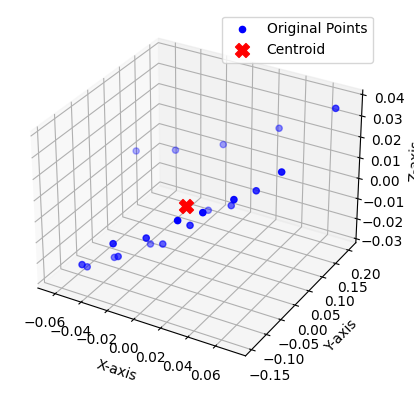

In [23]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plotting the original points
ax.scatter(normalized_points[:, 0], normalized_points[:, 1], normalized_points[:, 2], c='blue', label='Original Points')

# Plotting the centroid
ax.scatter(0,0,0, c='red', marker='X', s=100, label='Centroid')

# Adding labels and legend
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_zlabel('Z-axis')
ax.legend()

# Display the 3D plot
plt.show()

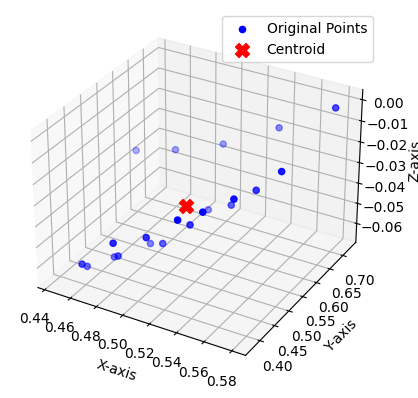

In [24]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plotting the original points
ax.scatter(points_array[:, 0], points_array[:, 1], points_array[:, 2], c='blue', label='Original Points')

# Plotting the centroid
ax.scatter(centroid[0], centroid[1], centroid[2], c='red', marker='X', s=100, label='Centroid')
#ax.scatter(0,0,0, c='red', marker='X', s=100, label='Centroid')
# Adding labels and legend
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_zlabel('Z-axis')
ax.legend()

# Display the 3D plot
plt.show()

In [66]:
for etapa in range(1,7):
    cap = cv2.VideoCapture("Videos-home/Step"+str(etapa)+".mp4")#Videos-home/Paso1.mp4
    with mp_hands.Hands(model_complexity=0, min_detection_confidence=0.5, min_tracking_confidence=0.5, max_num_hands = 2, ) as hands:
        while cap.isOpened():
            success, image = cap.read()
            if not success:
                print("Ignoring empty camera frame.")
            # If loading a video, use 'break' instead of 'continue'.
                break
            # To improve performance, optionally mark the image as not writeable to
            # pass by reference.
            #image.flags.writeable = True
            #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            results = hands.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

            #Draw the hand annotations on the image.
            #image.flags.writeable = False
            #image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
            height, width, _ = image.shape

            if results.multi_hand_landmarks:

                for hand_landmarks in results.multi_hand_landmarks:
                    mp_drawing.draw_landmarks(
                    image,
                    hand_landmarks,
                    mp_hands.HAND_CONNECTIONS,mp_drawing.DrawingSpec(color=(0,255,255), thickness=2, circle_radius=3),
                    mp_drawing.DrawingSpec(color=(255,0,255), thickness=2, circle_radius=3))

                # verificar primero la cantidad de landmarks
                if len(results.multi_hand_landmarks) == 1:
                    variable =results.multi_handedness[0].classification[0].label
                elif len(results.multi_hand_landmarks) == 2:
                    variable = 'Both'
                else:
                    variable = None

                #try:
                if variable =="Left":
                    mano_dere_row = np.zeros(63)
                    mano_izq_row = np.array([[landmark.x, landmark.y,landmark.z] for landmark in results.multi_hand_landmarks[0].landmark]).flatten()
                elif variable == "Right":
                    mano_izq_row = np.zeros(63)
                    mano_dere_row = np.array([[landmark.x, landmark.y, landmark.z] for landmark in results.multi_hand_landmarks[0].landmark]).flatten()
                elif variable == "Both":
                    mano_dere_row = np.array([[landmark.x, landmark.y,landmark.z] for landmark in results.multi_hand_landmarks[0].landmark]).flatten()
                    mano_izq_row = np.array([[landmark.x, landmark.y, landmark.z] for landmark in results.multi_hand_landmarks[1].landmark]).flatten()
                else:
                    print('Error, se reconocen mas de dos manos')
                print("va en el paso", etapa)
                rows = np.concatenate((np.array([etapa]),mano_dere_row,mano_izq_row))
                print(rows)
                rows = np.where(rows ==0, np.nan,rows)
                centroid_x = np.nanmean(rows[1::3])
                centroid_y = np.nanmean(rows[2::3])
                centroid_z = np.nanmean(rows[3::3])
                rows = np.where(np.isnan(rows), 0, rows)
                rows[1::3] -= centroid_x
                rows[2::3] -= centroid_y
                rows[3::3] -= centroid_z
                    
                with open('Avianca2.csv', mode='a', newline='') as f:
                    csv_writer = csv.writer(f, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
                    csv_writer.writerow(rows) 

            cv2.imshow('Paso '+str(etapa), image)
            if cv2.waitKey(5) & 0xFF == 27:
                break
        cap.release()
        cv2.destroyAllWindows()

In [2]:
num_coords = 42
landmarks = ['class']
for val in range(1, num_coords+1):
    landmarks += ['x{}'.format(val), 'y{}'.format(val), 'z{}'.format(val)]